# Implementing a Kalman Filter via Julia
| Katie Oliveras - Last Update - 18 February 2021

In [9]:
using LinearAlgebra
using Plots

# gr()
# plotly();
pyplot()
# pgfplotsx()


Plots.PyPlotBackend()

## Generating the System States and the Observations
Let $x_k$ is a vector of the position and velocity states of a object.  Here, $$x_k = \begin{bmatrix}s_{x,k}\\s_{y,k}\\v_{x,k}\\v_{y,k}\end{bmatrix}$$Here, we would like to simulate the following system
\begin{align*}
x_{k + 1} &= F x_k + G u_k + w_k\\
y_k &= H_kx_k + v_k
\end{align*}
where we will assume $$F = \begin{bmatrix}1& 0 & \Delta t& 0\\ 0& 1& 0& \Delta t\\ 0& 0 &1-b& 0\\ 0& 0& 0 &1-b\end{bmatrix}, \qquad G = \begin{bmatrix}0\\0\\0\\\Delta t\end{bmatrix}$$ 

It should not be much work to realize that the discrete system is simply a one-step estimate of the continunous system $$\dot{x}(t) = Ax(t) + u(t) + w(t), \qquad y(t) = H x(t) + v(t)$$

We furthermore assume that the $v$ and $w$ are not correlated.  Now, assuming that 
$$\mathbb{E}\left[v_k v_k^\textsf{T}\right] = R \qquad \mathbb{E}\left[w_k w_k^\textsf{T}\right] = Q$$
we first start by simulating the noisy data and noisy observations that we will need for our filter implementation

In [10]:
dt = 0.1;
b = 1e-4;
g = 9.8;
numIterations = 1200;

F = [1 0 dt 0; 0 1 0 dt; 0 0 1-b 0; 0 0 0 1-b];
G = [0;0;0;dt]
U = -g;
H = [1 0 0 0; 0 1 0 0];

X0 = [0;0;300;600];

# Using the provided assumptions for the covariance matrices in the noise
# Note: In Julia - I is the identity matrix - it automatically scales when needed.  Cool.
Q = 1e-1*I;
R = 500*I;

# Initialize Storage Matrices for Plotting and Using Data Later on
XTOut = zeros(4,numIterations); XTOut[:,1] = X0;
XROut = zeros(4,numIterations); XROut[:,1] = X0;
YOut = zeros(2,numIterations); YOut[:,1] = H*X0 + R*(rand(2,1) - .5*ones(2,1))*2;



## Generate the Data

In [11]:
for k = 2:numIterations
    XTOut[:,k] = F*XTOut[:,k-1] + G*U;
    XROut[:,k] = XTOut[:,k] + .001*XTOut[:,k].^2 + Q*(rand(4,1)-.5*ones(4,1))*2
    YOut[:,k] = H*XTOut[:,k] + R*(rand(2,1) - .5*ones(2,1))*2
end

### Ploting both the observed data and true data for position $(s_x(k), s_y(k))$

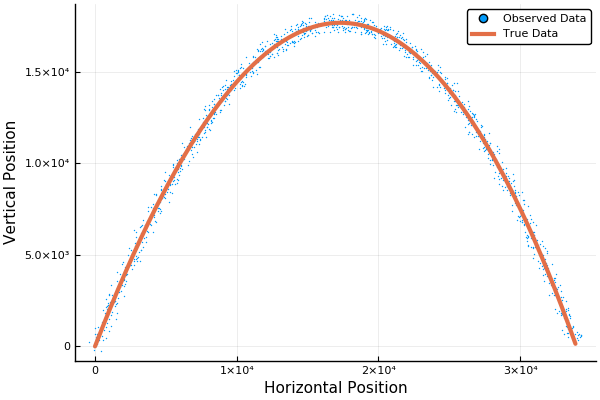

In [12]:
plot(YOut[1,:],YOut[2,:],  label="Observed Data",  xlabel="Horizontal Position",ylabel="Vertical Position",markersize=1,markerstrokewidth=0,t=[:scatter])
plot!(XTOut[1,:],XTOut[2,:], label="True Data",linewidth=3)


## Implementing the Kalman Filter

Beginning with an estimate for the state and covariance of the error, we use the following:

Given an initial prediction $P_k'$ and $\hat{x}_k'$: 
* Find the **Kalman Gain Matrix** $K = (HP_k')^\textsf{T}(H P_k'H^\textsf{T} + R)^{-1}$
* **Correct** the predicted values 
   * Correct the state estimate $\hat{x}_k = \hat{x}_k' + K(y_k - H\hat{x}_k')$
   * Correct the covariance $P_k = (I - K H)P_k'$
* **Prepare** for the next iteration by adjusting the predicted values
   * Update the covariance $P_k' = F P_kF^\textsf{T} + Q$ 
   * Update the predicted state $\hat{x}_k' = F \hat{x}_k + G u$

In [5]:
P = 200*Q;
startFilter = 1;

# initialize prediction using observed state and zeros for the velocity
Xp = zeros(4,1);
Xp[1:2,1] = YOut[:,startFilter]

XKOut = zeros(4,numIterations);


for k=startFilter:numIterations
    # Compute the Kalman Gain Matrix
    K = (H*P)'*inv(H*P*H' + R);
    # Correct the estimate based on observations and the "Predicted" x state
    XKOut[:,k] = Xp + K*(YOut[:,k] - H*Xp);
    
    # Update the Covariance and State "Predictions"
    P = F*((I - K*H)*P)*F' + Q;
    Xp = F*XKOut[:,k] + G*U
end

# Fun with Plotting the Output
In the cell below, we plot the observed values for the position, as well as the true (noiseless) signal and the Kalman filter estimate.  

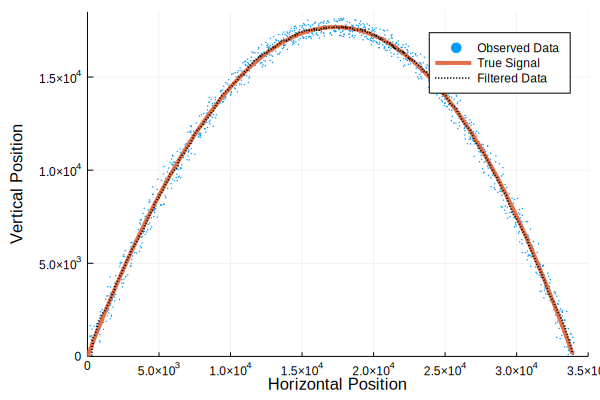

In [6]:
xplotrange = (0, 35000)
yplotrange = (0,18500)
plot(YOut[1,:],YOut[2,:],xlabel="Horizontal Position",ylabel="Vertical Position",label="Observed Data",markersize=1,markercolor=palette(:default)[1],markerstrokewidth=0,t=[:scatter],xlim=xplotrange, ylim=yplotrange)#,t=[:scatter],markerstrokewidth=0,markersize=3)
plot!(XTOut[1,:],XTOut[2,:], label="True Signal",line=(:solid,4),linecolor=palette(:default)[2],xlim=xplotrange)
plot!(XKOut[1,:],XKOut[2,:], label="Filtered Data",line=(:dot,2,:black),xlim=xplotrange)


## Zooming in on the fun

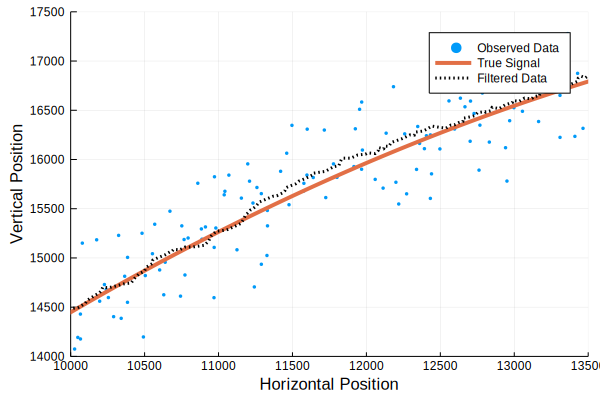

In [7]:
xplotrange = (10000, 13500)
yplotrange = (14000,17500)
plot(YOut[1,:],YOut[2,:],xlabel="Horizontal Position",ylabel="Vertical Position",label="Observed Data",markersize=2,markerstrokewidth=0,t=[:scatter],linewidth=4,xlim=xplotrange, ylim=yplotrange)#,t=[:scatter],markerstrokewidth=0,markersize=3)
plot!(XTOut[1,:],XTOut[2,:], label="True Signal",line=(:solid,4),linecolor=palette(:default)[2],xlim=xplotrange)
plot!(XKOut[1,:],XKOut[2,:], label="Filtered Data",line=(:dot,3,:black),xlim=xplotrange)



## Looking at the Relative Error


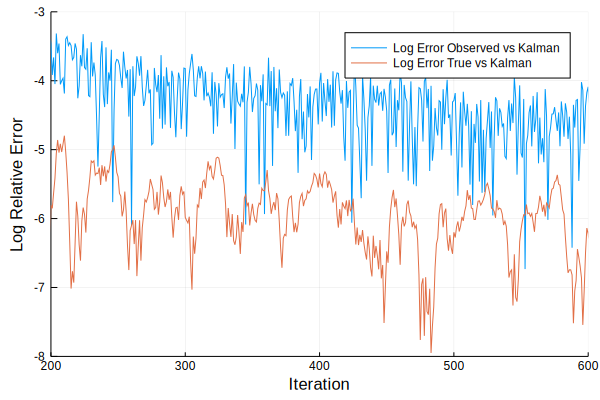

In [8]:
errorTrueKalman = (sqrt.(sum((XTOut - XKOut).^2,dims=1))./sum(abs.(XKOut),dims=1))';
errorObservedKalman = (sqrt.(sum((YOut - XKOut[1:2,:]).^2,dims=1))./sum(abs.(YOut),dims=1))';

plot(log.(errorObservedKalman),label="Log Error Observed vs Kalman",xlim=(200,600))
plot!(log.(errorTrueKalman),label="Log Error True vs Kalman",xlim=(200,600),ylim=(-8,-3),xlabel="Iteration",ylabel="Log Relative Error")
